In [1]:
import jax.numpy as jnp
from jax import jit,grad,hessian
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt

import jax

key = jax.random.PRNGKey(420)
from scipy.interpolate import CloughTocher2DInterpolator

def resample(X,y,m_interp=40):
    interp = CloughTocher2DInterpolator(X, y,fill_value=0)
    xgrid,ygrid = np.linspace(0,1,m_interp),np.linspace(0,1,m_interp)
    meshX,meshY=np.meshgrid(xgrid,ygrid)
    return xgrid,ygrid,interp(meshX,meshY)


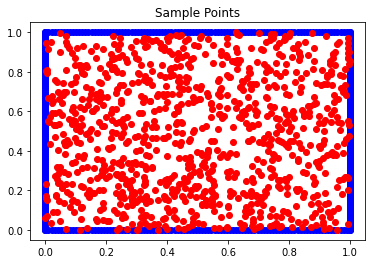

In [56]:
num_interior=1000

num_per_boundary=100
num_boundary=4*num_per_boundary


interior_points = jax.random.uniform(key,shape=(num_interior,2),minval=0,maxval=1)

boundary_point_samples=np.linspace(0,1,num_per_boundary)
boundary_points = np.hstack([
    np.vstack((np.zeros(num_per_boundary),boundary_point_samples)),
    np.vstack((np.ones(num_per_boundary),boundary_point_samples)),
    np.vstack((boundary_point_samples,np.ones(num_per_boundary))),
    np.vstack((boundary_point_samples,np.zeros(num_per_boundary)))
]).T

all_points = jnp.vstack([interior_points,boundary_points])

plt.title("Sample Points")
plt.scatter(boundary_points[:,0],boundary_points[:,1],c='blue')
plt.scatter(interior_points[:,0],interior_points[:,1],c='red')
plt.show()

## Build and vectorize kernel functions

In [57]:
def get_gaussianRBF(gamma):
    def f(x,y):
        return jnp.exp(-jnp.sum((x-y)**2)/gamma)
    return f

def laplacian(f,arg_num=0):
    hess=hessian(f,argnums=arg_num)
    def lap(x,y):
        return jnp.trace(hess(x,y))
    return lap

k= get_gaussianRBF(0.05)
k_lapx = laplacian(k,arg_num=0)
k_laplap = laplacian(k_lapx,arg_num=1)


vec_k = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))
vec_k_lapx = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))
vec_k_laplap = jax.vmap(jax.vmap(k, in_axes=(0, None)), in_axes=(None, 0))


## Build Kernel Matrix

In [58]:
K1 = vec_k_laplap(interior_points,interior_points)
K2 = vec_k_lapx(boundary_points,interior_points)
K3 = K2.T
K4 = vec_k(boundary_points,boundary_points)

K_full = jnp.block(
    [
        [K1,K2],
        [K3,K4]
    ]
)

## Define forcing function on RHS and work out RHS vector for system

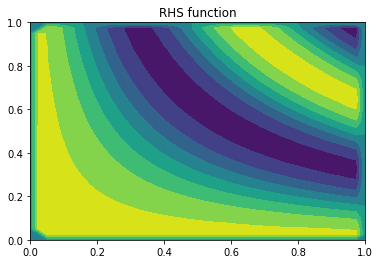

In [59]:
def rhs_func(x):
    return np.cos(10*x[:,0]*x[:,1])

xgrid,ygrid,f_rhs = resample(interior_points,rhs_func(interior_points))
plt.title("RHS function")
plt.contourf(xgrid,ygrid,f_rhs)

interior_rhs = rhs_func(interior_points)
boundary_rhs = jnp.zeros(num_boundary)
rhs_total = jnp.hstack([interior_rhs,boundary_rhs])

## Solve linear system for Coefficients

Text(0.5, 1.0, 'RHS function')

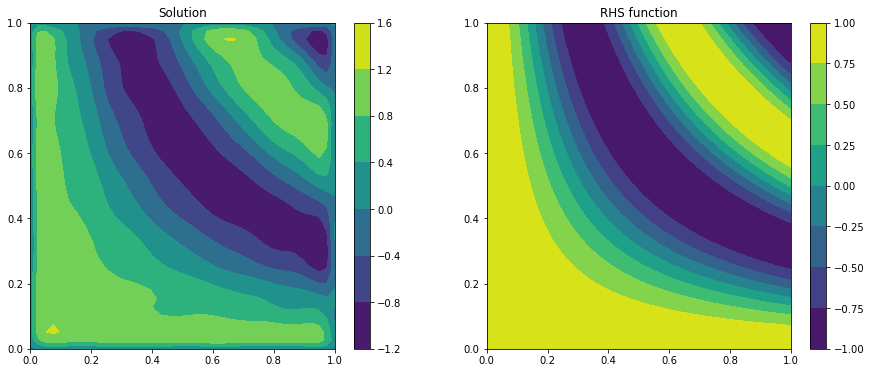

In [61]:
coef_sol=jnp.linalg.solve(K_full+0.00001*jnp.identity(num_interior+num_boundary),rhs_total)

eval_K=vec_k(interior_points,jnp.vstack([interior_points,boundary_points])).T
sol_vals = eval_K@coef_sol



xgrid=jnp.linspace(0,1,40)
ygrid=jnp.linspace(0,1,40)

XX,YY=jnp.meshgrid(xgrid,ygrid)

interpolation_points = jnp.vstack([XX.flatten(),YY.flatten()]).T

interp_solution=(vec_k(all_points,interpolation_points)@coef_sol).reshape(40,40)
interp_rhs = rhs_func(interpolation_points).reshape(40,40)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
plot1=ax1.contourf(xgrid,ygrid,interp_solution)
ax1.set_title("Solution")
plt.colorbar(plot1,ax=ax1)
plot2=ax2.contourf(xgrid,ygrid,interp_rhs)
plt.colorbar(plot2,ax=ax2)

ax2.set_title("RHS function")

